In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import timeit

import pandas as pd

import re

from haversine import haversine

from mpl_toolkits.basemap import Basemap

$$
PART.3 - SIMULATED-ANNEALING
$$
**Index**

1. Load data
2. Investigate completeness of meshgrid (interconnections between any 2 airports)
3. Compute distance between all 309 airports
4. Predicted flight time between all airports using OLS
5. Finding the optimal flight path between a subset of 20 airports using modeled delay times
    a) Greedy algorithm solution
    b) Simulated annealing
6. Plots of itineraries

In [2]:
## Load flight data
data = pd.read_csv('FlightDelaySub.csv')
origin = data.ORIGIN
destination = data.DEST
elapsed_time = data.CRS_ELAPSED_TIME

## Load GEO coordinates data
geo_info_df = pd.read_csv('Airport_Codes_mapped_to_Latitude_Longitude_in_the_United_States.csv')
geo_info_df.head(1)

## Load delay outputs
mod_output_NM = pd.read_csv('NormalPercentiles.csv') # normal model
mod_output_NBM = pd.read_csv('NBinPercentiles.csv') # negative binomial model

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Create list of unique airports

In [3]:
# Create list of unique airports in data set with indexes
all_airports=origin.append(destination)
unique_airports = list(set(all_airports))

In [4]:
# Transform in to numpy matrix
origin = np.array(origin)
destination = np.array(destination)
elapsed_time = np.array(elapsed_time)
mat_flights = (np.vstack((origin, destination, elapsed_time))).T

# Replace Airport abbreviations in flight data with indices
all_connections = mat_flights.copy()
for i in all_connections:
    for j in range(0,2):
        i[j]=unique_airports.index(i[j])

We originally attempted to run the simulated annealing on the real data including only those connections that are included in our dataset. However, as the dataset comprises a total of 309 airports including many small, remote airports with only one connection, our traveler would not be able to visit every airport only once/be stuck in a location that he could only leave via the same connecting flight. 
This is nicely illustrated by the plotted mesh of the interconnections between airports. The airports that can be considered hubs have the largest number of points.

Number of possible connections:  4040


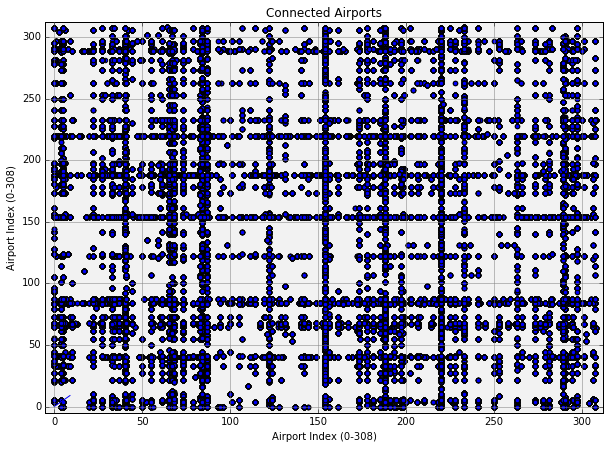

In [5]:
# Plotting the meshgrid that shows which airports are connected by a flight in the dataset
possible_connections_graph = np.zeros([len(unique_airports),len(unique_airports)])
possible_connections = np.zeros(len(unique_airports)**2)
x=[]
y=[]
for i in range(len(all_connections)):
    possible_connections_graph[all_connections[i,0],all_connections[i,1]]=1
    possible_connections[all_connections[i,0]*(len(unique_airports))+all_connections[i,1]]=1
    x.append(all_connections[i,0])
    y.append(all_connections[i,1])

print "Number of possible connections: ", np.sum(possible_connections_graph).astype(int)

# Plot existing connections as meshgrid
fig= plt.figure(figsize=(10,7))
plt.scatter(x,y)
ax = fig.add_subplot(111)
ax.plot(range(10))
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(0.1)
plt.title("Connected Airports")
plt.xlabel("Airport Index (0-308)")
plt.ylabel("Airport Index (0-308)")
plt.xlim(-5,312)
plt.ylim(-5,312)
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.savefig('fig.pdf')
plt.show()

We thus decided to infer the hypothetical flight time between any pair of airports included our data set based on a geographical distance, to allow us to generate a fully meshed grid.

In order to do this we first had to create a matrix that listed the geo-location of each of our 309 airports. The aiports were then indexed in the same way as our flight data, with each 'xyz'-airport code coninciding with an index between 0 and 308.

In [6]:
# Generate list of geo data with indices for airports
geo_info = unique_airports
geo_info = pd.DataFrame(geo_info, columns=['locationID'])
geo_info = geo_info.merge(geo_info_df)
geo_info = np.array(geo_info)

# Add missing airport locations to geo_info to generate complete geo data
add_missing_airports = [['YUM', 32.6683, 114.5989],
                        ['PSC', 46.2595, 119.1146],
                        ['RDM', 44.2538, 121.1509], 
                        ['ACV', 40.9775, 124.1085], 
                        ['ICT', 37.6509, 97.4287], 
                        ['RDU', 35.8801, 78.7880], 
                        ['LWS', 46.3759, 117.0160],
                        ['SCE', 40.8559, 77.8438],
                        ['FCA', 48.3111, 114.2542],
                        ['ECP', 30.3529, 85.7943],
                        ['MQT', 46.3487, 87.3952],
                        ['CLD', 33.1266, 117.2788],
                        ['UST', 29.9551, 81.3421]]
geo_info_cpt = np.concatenate((geo_info, np.zeros((len(add_missing_airports), 3))))
for i in range((len(geo_info_cpt)-len(add_missing_airports)), len(geo_info_cpt)):
    geo_info_cpt[i]=add_missing_airports[i-(len(geo_info_cpt)-len(add_missing_airports))]

# Replace airport IDs with indexes
geo_info_idx=geo_info_cpt.copy()
for i in geo_info_idx:
    for j in range(0,1):
        i[j]=unique_airports.index(i[j])
        
# Sort matrix of geo coordinates according to indexes (each index indicating one airport)
geo_info_idx_new = np.zeros((len(geo_info_idx),3))
for i in range(len(geo_info_idx)):
    #print [geo_info_idx[i,0]]
    geo_info_idx_new[geo_info_idx[i,0]] = geo_info_idx[i,:]
geo_info_idx_new = geo_info_idx_new[0:309]

**Distances between the 309 airports**

We then computed the distance between any two of the 309 airports using the haversine package and stored the information in a 309 by 309 matrix

In [7]:
# Compute distances between any two airports
coordinates_only = geo_info_idx_new[:,1:3]
distance_mat = np.zeros((len(geo_info_idx_new), len(geo_info_idx_new)))
for i in range(len(geo_info_idx_new)):
    for j in range(len(geo_info_idx_new)):
        distance_mat[i,j]=haversine(coordinates_only[i], coordinates_only[j])

**Ordinary Least Squares regression to predict flight times between any two airports**

We computed an OLS solution using distance between any two airports to predict the flight times between each pair
$$
\alpha=[X^T X]^{-1}X^T Y
$$
with $Y$ being the flight time and $X$ being the distance between two airports i and j.

In order to do this we first had to compute the mean flight time for each itinerary from our dataset.

In [8]:
# Sum up flight times for same itinerary
sum_flight_time = np.zeros([len(unique_airports),len(unique_airports)])
number_of_flights = np.zeros([len(unique_airports),len(unique_airports)])
for i in range(len(all_connections)-1):
    number_of_flights[all_connections[i,0], all_connections[i,1]] += 1
    sum_flight_time[all_connections[i,0], all_connections[i,1]] += all_connections[i,2]

# Average the flight time for each itinerary
avg_flight_time= np.zeros([len(unique_airports),len(unique_airports)])
for i in range(len(unique_airports)):
    for j in range(len(unique_airports)):
        if number_of_flights[i,j] == 0:
            continue
        else:
            avg_flight_time[i,j] = np.divide(sum_flight_time[i,j], number_of_flights[i,j])

We then used the observed flight time and the distances between the aiport locations to compute the least squares solution.

Intercept: [[ 42.3276401]]
Flight time prediction [in min] per km of distance:  [[ 0.07513292]]


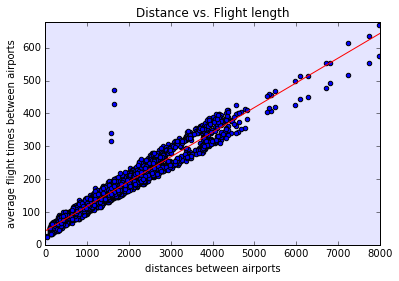

In [9]:
# Make a vector of flight times and distances from data
list_flight_times = np.ndarray.flatten(avg_flight_time)
list_distances = np.ndarray.flatten(distance_mat)

OLS_distances = []
OLS_flight_times = []

for i in range(len(list_flight_times)):
    if list_flight_times[i]==0:
        continue
    else:
        OLS_distances.append(list_distances[i])
        OLS_flight_times.append(list_flight_times[i])   


OLS_distances = (np.mat(OLS_distances)).T
OLS_flight_times = (np.mat(OLS_flight_times)).T

# Add column of ones to vector X (distances) for the intercept
OLS_X = np.hstack((np.ones((len(OLS_distances),1)), OLS_distances))

# estimate alpha using least squares approx.
alpha = np.linalg.inv(OLS_X.T.dot(OLS_X)).dot(OLS_X.T).dot(OLS_flight_times)

print "Intercept:", alpha[0]
print "Flight time prediction [in min] per km of distance: ", alpha[1]


# Plot data points and least squares regression
X = (np.linspace(0, 8010, 8011)).astype(int)
Y = np.zeros(len(X))
for i in X:
    Y[i]=alpha[0]+np.int(X[i])*alpha[1]

fig = plt.figure()
plt.scatter(OLS_distances, OLS_flight_times)
plt.plot(X, Y, color="r", alpha=1)
plt.xlabel("distances between airports")
plt.ylabel("average flight times between airports")
plt.title("Distance vs. Flight length")
plt.ylim(0, np.max(OLS_flight_times))
plt.xlim(0, np.max(OLS_distances))
# colour plot
ax = fig.add_subplot(111)
ax.plot(range(10))
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.1)
plt.savefig('OLS_flighttime.png')
plt.show()

The four outliers contain connections between Honolulu, American Samoa and Guam Guam which are connected by an island hopper airplane which takes longer than the usual aircrafts. We thus found geographical distance to be a good predictor of flight time in almost all cases. In our least square solution the intercept the reflective of the time of take off and landing, which are almost constant for all connections irrespective of distance.

We thus used the OLS solution to compute the hypothetical flight time between all of our 209 airports

In [10]:
hypo_flight_time = np.zeros((len(unique_airports), len(unique_airports)))
for i in range(len(hypo_flight_time)):
    for j in range(len(hypo_flight_time)):
        hypo_flight_time[i,j] = alpha[0]+distance_mat[i,j]*alpha[1]

** Simulated Annealing **

The purpose of simulated annealing was to find optimal flight paths that made used of the modeled delay data from the negative binomial model and took into account the riks perception of the traveler.

We intended to find an optimal flight path that would visit each of the 29 airports for which we had modeled delay lengths.

In order to apply simulated annealing it is not only a prerequisite to have a well populated grid but also to divise a sensible starting point.

As we were interested in comparing the simulated annealing algorithm to a greedy algorithm, we first computed the greed algorithm solution and then used it as the starting itinerary for simulated annealing.

In order to compare the effect of traveler's risk perception, we ran the greedy algorithm on three scenarios.

**Scenario 1** risk loving:

$\sum$ flight time$_{ij} + $25th percentile of delay$_{ij}$

**Scenario 2** Median:

$\sum$ flight time$_{ij} + $50th percentile of delay$_{ij}$

**Scenario 3** risk averse:

$\sum$ flight time$_{ij} + $75th percentile of delay$_{ij}$

In [11]:
# Create matrix including the delay percentiles
# Format: [Origin],[Destination], 25th, 50th, and 75th percentile

# Output from the negative binomial model
delays_NBM = np.array(mod_output_NBM)
delays_NBM = (np.vstack((delays_NBM[:,6], delays_NBM[:,7], delays_NBM[:,3],delays_NBM[:,4],delays_NBM[:,5]))).T
print delays_NBM.shape

(812, 5)


In [12]:
# Create new indexed list for subset
unique_airports_subset = list(set(delays_NBM[:,0]))

In [13]:
# create delay matrix including full lenght indices (0-308) instead of a"XYZ"-codes
delay_mat_idx_subset = delays_NBM.copy()
for i in delay_mat_idx_subset:
    for j in range(0,2):
        i[j]=unique_airports.index(i[j])

# create delay matrix including subset indices (0-29) instead of a"XYZ"-codes
delay_mat_idx = delays_NBM.copy()
for i in delay_mat_idx:
    for j in range(0,2):
        i[j]=unique_airports_subset.index(i[j])
    
# Retrieve flight times from complete hypothetical flight time matrix
hypo_flight_times_subset = np.zeros((len(delay_mat_idx_subset)))        
for i in range(len(delay_mat_idx_subset)):
               hypo_flight_times_subset[i] = hypo_flight_time[delay_mat_idx_subset[i,0], delay_mat_idx_subset[i,1]]

We then created a greedy algorithm function which would choose the airport with shortest total flight time as the next airport and a function that allows us to compute the total flight time of an itinerary.

In [14]:
def greedy_algorithm(matrix):
    itinerary = []
    start = unique_airports_subset.index('SJU')
    itinerary.append(start)
    
    now = start
    
    while (len(itinerary))<29:
        found = False
        options = matrix[now,:]
        options_deletable = matrix[now,:]
    
        while not found:
            proposed = np.min(options_deletable)
            index = np.where(options == proposed)[0]
            index_delete = np.where(options_deletable == proposed)[0]

            if np.int(proposed) != 0 and index not in itinerary:
                itinerary.append(index[0])
                now = index[0]
                found = True
        
            else:
                options_deletable = np.delete(options_deletable, index_delete, axis=0)
    return itinerary

In [15]:
# Function computes total flight time of itinerary
def compute_energy(proposed_airport_itinerary, flight_time_delays):
    new_travel_time=0
    for i in range(0,len(proposed_airport_itinerary)-1):
        new_travel_time +=(flight_time_delays[np.int(proposed_airport_itinerary[i]),np.int(proposed_airport_itinerary[i+1])])
    return new_travel_time

And ran it on our data set of 29 airports and 3 scenarios.

In [17]:
# Generate matrices of flight + delay length for each percentile
mat_NBM_25 = np.zeros((len(unique_airports_subset), len(unique_airports_subset)))
mat_NBM_50 = np.zeros((len(unique_airports_subset), len(unique_airports_subset)))
mat_NBM_75 = np.zeros((len(unique_airports_subset), len(unique_airports_subset)))
for i in range(len(delay_mat_idx[:,0])):
    mat_NBM_25[delay_mat_idx[i,0], delay_mat_idx[i,1]]= delay_mat_idx[i,2]+hypo_flight_times_subset[i]
    mat_NBM_50[delay_mat_idx[i,0], delay_mat_idx[i,1]]= delay_mat_idx[i,3]+hypo_flight_times_subset[i]
    mat_NBM_75[delay_mat_idx[i,0], delay_mat_idx[i,1]]= delay_mat_idx[i,4]+hypo_flight_times_subset[i]

In [18]:
initial_NBM_25 = greedy_algorithm(matrix=mat_NBM_25)
initial_NBM_50 = greedy_algorithm(matrix=mat_NBM_50)
initial_NBM_75 = greedy_algorithm(matrix=mat_NBM_75)

# Translate back into "XYZ" codes
greedy_solution_xyz = []
for i in initial_NBM_50:
    greedy_solution_xyz.append(unique_airports_subset[i])

print initial_NBM_25
print initial_NBM_50
print initial_NBM_75
print "Flight time greedy algorithm:", compute_energy(initial_NBM_25, mat_NBM_25)/60,compute_energy(initial_NBM_50, mat_NBM_50)/60, compute_energy(initial_NBM_75, mat_NBM_75)/60

[12, 5, 2, 1, 13, 26, 19, 27, 11, 8, 25, 16, 6, 4, 21, 17, 28, 0, 23, 24, 18, 20, 10, 15, 7, 22, 9, 14, 3]
[12, 5, 2, 1, 13, 26, 19, 27, 11, 8, 25, 16, 6, 4, 21, 17, 28, 0, 23, 24, 18, 20, 10, 15, 7, 22, 9, 14, 3]
[12, 5, 2, 1, 13, 26, 19, 27, 11, 8, 25, 16, 6, 4, 21, 17, 28, 0, 23, 24, 18, 20, 10, 15, 7, 22, 9, 14, 3]
Flight time greedy algorithm: 42.9328920785 43.7287254118 45.1745587452


We find that while the total flight time for each scenario differs, the itinerary of hte greedy algorithm for each scenario is the same.

In order to no do the simulated annealing we needed to create a function that would allow us to swap 2 airports of our itinerary, a function that checks whether a proposed itinerary exists (not necessary in our fully meshed case, but can account for the fact, if not all connections existed) and the simulated annealing itself.

**Functions for simulated annealing**
1. swap airports
2. check validity of itinerary 
3. simulates annealing

In [19]:
def swap_airports(airport_itinerary, flight_time_delays):
    tmp_airport_itinerary = airport_itinerary[:]
    indices = range(len(tmp_airport_itinerary))
    check=-1
    count=0
    # select 1st indice to be swapped
    ap1 = np.random.choice(indices)

    
    while check < 0:
        ap2 = np.random.choice(indices)
    
        while ap2 == ap1:
            ap2 = np.random.choice(indices)
        
        # remember the airports to swap
        tmp1 = tmp_airport_itinerary[ap1]
        tmp2 = tmp_airport_itinerary[ap2]

        # generate test itinerary with proposed switch
        test_itinerary = tmp_airport_itinerary
        test_itinerary[ap1] = tmp2
        test_itinerary[ap2] = tmp1
        
        check=check_itinerary(test_itinerary, flight_time_delays)
        
        if check > 0:
            proposed_airport_itinerary = test_itinerary
            break
        count+=1
    
    return proposed_airport_itinerary

In [20]:
# Function checks whether itinerary exists
def check_itinerary(test_itinerary, flight_time_delays):
    for i in range(len(test_itinerary)-1):
        if flight_time_delays[np.int(test_itinerary[i]), np.int(test_itinerary[i+1])] == 0:
            check=-1
            break
        else:
            check=1
    return check

In [37]:
def simulated_annealing(flight_time_delays, initial_itinerary, initial_temperature, thermostat, reannealing, ra_temperature, total_it):
    
    # Initialise number of completed iterations and number of accepted steps
    atp = 0
    acc = 0 

    # Set initial temperature
    temperature=initial_temperature

    # Set initial airport itinerary
    airport_itinerary=initial_itinerary

    # Compute energy of initial itinerary
    prev_E = compute_energy(airport_itinerary, flight_time_delays)

    # initialise optimal itinerary
    maximum=[prev_E]
    all_E=[prev_E]
    optimal_itinerary=[airport_itinerary]
    
    for i in range(total_it):
    
        # propose new itinerary
        proposed_airport_itinerary = swap_airports(airport_itinerary, flight_time_delays)
        #print prev_E
    
        # compute change in energy
        new_E = compute_energy(proposed_airport_itinerary, flight_time_delays)
        delta_E = np.log10(new_E - prev_E) # will be > 0 if proposal is worse than current state
    
        # accept if total flight time is reduced
        if new_E < prev_E:
            airport_itinerary = proposed_airport_itinerary
            prev_E = new_E
            acc += 1
    
        # accept if coin flip is smaller than exp(delta_E/T)
        elif np.random.rand() < np.exp( -(delta_E / temperature)):
            airport_itinerary = proposed_airport_itinerary
            prev_E = new_E
            acc += 1
        
        #print prev_E
        all_E.append(prev_E)
        atp+=1 # count up iterations
    
        # save itinerary if new optimum
        if prev_E < maximum[len(maximum)-1]:
            maximum.append(prev_E)
            optimal_itinerary.append(airport_itinerary)
    
        # test whether its time to cool down
        if acc % reannealing == 0:
            temperature = thermostat * temperature;
        
            #if we get too cold, reheat 
            if temperature < 0.01:
                temperature = ra_temperature
        
        # break after total_it iterations
        if atp > total_it:
            print "done"
            break
    
    return maximum, optimal_itinerary, all_E, acc, atp

**Run simulated annealing with flight times and modeled delay times from negative binomal model (NBM)** using an initial temperature of 0.5, a slow linear cooling schedule of 0.95 times the previous temperature and an initial and reannealing temperature of 0.3.

In [58]:
initial_temperature=0.5
t0=time.clock()
maximum_NBM_25, optimal_itinerary_NBM_25, all_E_NBM_25, acc_NBM_25, atp_NBM_25 = simulated_annealing(flight_time_delays=mat_NBM_25, 
                                                                  initial_itinerary = initial_NBM_25,
                                                                  initial_temperature = initial_temperature, 
                                                                  thermostat = 0.95, 
                                                                  reannealing = 100,
                                                                  ra_temperature = 0.3,
                                                                  total_it = 100000)
maximum_NBM_50, optimal_itinerary_NBM_50, all_E_NBM_50, acc_NBM_50, atp_NBM_50 = simulated_annealing(flight_time_delays = mat_NBM_50,
                                                                  initial_itinerary = initial_NBM_50,
                                                                  initial_temperature = initial_temperature, 
                                                                  thermostat = 0.95, 
                                                                  reannealing = 100, 
                                                                  ra_temperature = 0.3,
                                                                  total_it = 100000)
maximum_NBM_75, optimal_itinerary_NBM_75, all_E_NBM_75, acc_NBM_75, atp_NBM_75 = simulated_annealing(flight_time_delays=mat_NBM_75,
                                                                  initial_itinerary = initial_NBM_75,
                                                                  initial_temperature = initial_temperature, 
                                                                  thermostat = 0.95, 
                                                                  reannealing = 100, 
                                                                  ra_temperature = 0.3,
                                                                  total_it = 100000)
t1=time.clock()-t0

In order to see whether the functions we plot the energy function for the 3 scenarios and print the optimized itineraries for the three scenarios.

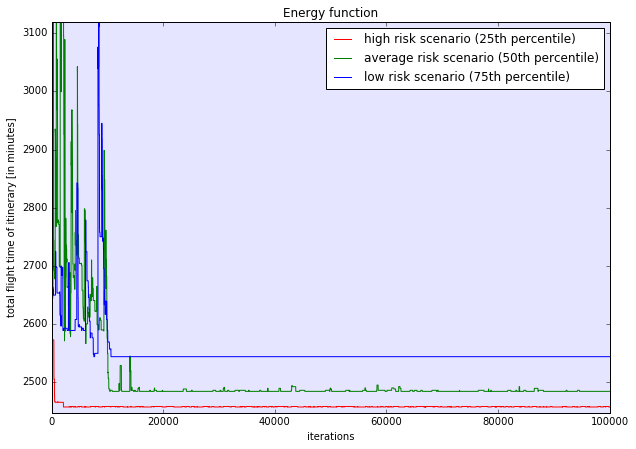

Optimal itineraries
25th percentile:
['SJU', 'MIA', 'FLL', 'GNV', 'CHS', 'IND', 'MCI', 'LAW', 'DFW', 'MAF', 'LBB', 'HDN', 'BIS', 'BOI', 'PSC', 'OTH', 'ACV', 'CIC', 'SFO', 'MMH', 'SBP', 'LGB', 'ELP', 'BRO', 'LFT', 'MLU', 'BUF', 'HPN', 'ISP']
50th percentile:
['CHS', 'ISP', 'HPN', 'BUF', 'IND', 'MCI', 'LAW', 'DFW', 'MAF', 'LBB', 'HDN', 'BIS', 'BOI', 'PSC', 'OTH', 'ACV', 'CIC', 'SFO', 'MMH', 'SBP', 'LGB', 'ELP', 'BRO', 'LFT', 'MLU', 'GNV', 'FLL', 'MIA', 'SJU']
75th percentile:
['SJU', 'MIA', 'FLL', 'GNV', 'CHS', 'MLU', 'LFT', 'BRO', 'DFW', 'LAW', 'LBB', 'HDN', 'BIS', 'BOI', 'PSC', 'OTH', 'ACV', 'CIC', 'SFO', 'MMH', 'SBP', 'LGB', 'ELP', 'MAF', 'MCI', 'IND', 'BUF', 'HPN', 'ISP']


In [59]:
# Plot the energy functions
fig = plt.figure(figsize=(10,7))
plt.plot(all_E_NBM_25, color='red', label="high risk scenario (25th percentile)")
plt.plot(all_E_NBM_50, color='green', label="average risk scenario (50th percentile)")
plt.plot(all_E_NBM_75, color='blue', label="low risk scenario (75th percentile)")

plt.xlabel('iterations')
plt.ylabel('total flight time of itinerary [in minutes]')
plt.title('Energy function')
plt.xlim(0,len(all_E_NBM_50))
plt.ylim(np.min(all_E_NBM_25)-10, np.max(all_E_NBM_75))
# colour plot
ax = fig.add_subplot(111)
ax.plot(range(10))
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.1)
plt.legend()
# Save figure
plt.savefig('Energy.png', transparent=True)

plt.show()

# Translate back to "XYZ"- codes
opt_NBM_25 = optimal_itinerary_NBM_25[np.argmin(maximum_NBM_25)]
opt_25_for_map_xyz = []
for i in opt_NBM_25:
    opt_25_for_map_xyz.append(unique_airports_subset[i])

opt_NBM_50 = optimal_itinerary_NBM_50[np.argmin(maximum_NBM_50)]
opt_50_for_map_xyz = []
for i in opt_NBM_50:
    opt_50_for_map_xyz.append(unique_airports_subset[i])

opt_NBM_75 = optimal_itinerary_NBM_75[np.argmin(maximum_NBM_75)]
opt_75_for_map_xyz = []
for i in opt_NBM_75:
    opt_75_for_map_xyz.append(unique_airports_subset[i])



print "Optimal itineraries" 
print"25th percentile:"
print opt_25_for_map_xyz
print "50th percentile:"
print opt_50_for_map_xyz
print "75th percentile:" 
print opt_75_for_map_xyz

**Plot the itineraries**

In order to view the itineraries on a map, we need to create vectors containing the itineraries as well as the airport locations.

In [61]:
# Inititalise matrix that will contain coordinates in addition to airports
greedy_solution_coordinates = (np.vstack((greedy_solution_xyz, np.zeros(len(opt_50_for_map_xyz)), np.zeros(len(opt_50_for_map_xyz))))).T
map_coordinates_25 = (np.vstack((opt_25_for_map_xyz, np.zeros(len(opt_50_for_map_xyz)), np.zeros(len(opt_50_for_map_xyz))))).T
map_coordinates_50 = (np.vstack((opt_50_for_map_xyz, np.zeros(len(opt_50_for_map_xyz)), np.zeros(len(opt_50_for_map_xyz))))).T
map_coordinates_75 = (np.vstack((opt_75_for_map_xyz, np.zeros(len(opt_50_for_map_xyz)), np.zeros(len(opt_50_for_map_xyz))))).T

for i in range(len(opt_50_for_map_xyz)):
    for j in range(1,3):
        greedy_solution_coordinates[i,j] = geo_info_idx_new[unique_airports.index(greedy_solution_xyz[i]),j]
        map_coordinates_25[i,j] = geo_info_idx_new[unique_airports.index(opt_25_for_map_xyz[i]),j]
        map_coordinates_50[i,j] = geo_info_idx_new[unique_airports.index(opt_50_for_map_xyz[i]),j]
        map_coordinates_75[i,j] = geo_info_idx_new[unique_airports.index(opt_75_for_map_xyz[i]),j]
        
# Transform into pandas data frame
# Greedy soltuion
greedy_solution_coordinates = pd.DataFrame(greedy_solution_coordinates, columns=['locationID', 'Latitude', 'Longitude'])
greedy_solution_coordinates['Longitude'] = greedy_solution_coordinates['Longitude'].astype(float)
greedy_solution_coordinates['Latitude'] = greedy_solution_coordinates['Latitude'].astype(float)
greedy_solution_coordinates['Longitude'] = greedy_solution_coordinates['Longitude'] *-1
# 25th percentile
map_coordinates_25 = pd.DataFrame(map_coordinates_25, columns=['locationID', 'Latitude', 'Longitude'])
map_coordinates_25['Longitude'] = map_coordinates_25['Longitude'].astype(float)
map_coordinates_25['Latitude'] = map_coordinates_25['Latitude'].astype(float)
map_coordinates_25['Longitude'] = map_coordinates_25['Longitude'] *-1

# 50th percentile
map_coordinates_50 = pd.DataFrame(map_coordinates_50, columns=['locationID', 'Latitude', 'Longitude'])
map_coordinates_50['Longitude'] = map_coordinates_50['Longitude'].astype(float)
map_coordinates_50['Latitude'] = map_coordinates_50['Latitude'].astype(float)
map_coordinates_50['Longitude'] = map_coordinates_50['Longitude'] *-1

# 75th percentile
map_coordinates_75 = pd.DataFrame(map_coordinates_75, columns=['locationID', 'Latitude', 'Longitude'])
map_coordinates_75['Longitude'] = map_coordinates_75['Longitude'].astype(float)
map_coordinates_75['Latitude'] = map_coordinates_75['Latitude'].astype(float)
map_coordinates_75['Longitude'] = map_coordinates_75['Longitude'] *-1

We use basemap to map the coordinates onto a map of the United States.

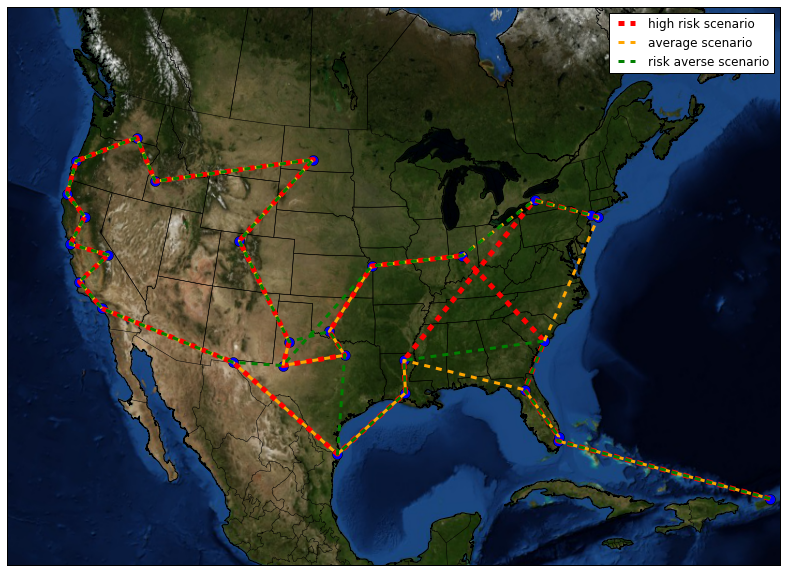

In [65]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(llcrnrlon=-120, llcrnrlat=15, urcrnrlon=-48,
              urcrnrlat=50, projection='lcc', lat_1=33, lat_2=45,
              lon_0=-95, resolution='i', area_thresh=10000)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()
map.drawstates()

# Fill the land with grey
map.bluemarble()

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')


# Plot 25th percentile
latitude_opt_25 = map_coordinates_25['Latitude'].values
longitude_opt_25 = map_coordinates_25['Longitude'].values
xx,yy = map(longitude_opt_25, latitude_opt_25)
for ind, val in enumerate(zip(xx,yy)):
    map.plot(val[0], val[1], 'bo', markersize=10)
plt.plot(xx,yy,color='red', ls='--',linewidth=5, label = u'high risk scenario')
# Plot 50th percentile
latitude_opt_50 = map_coordinates_50['Latitude'].values
longitude_opt_50 = map_coordinates_50['Longitude'].values
XX,YY = map(longitude_opt_50, latitude_opt_50)
plt.plot(XX,YY,color='orange' ,ls='--',linewidth=3, label = u'average scenario')
# Plot 75th percentile
latitude_opt_75 = map_coordinates_75['Latitude'].values
longitude_opt_75 = map_coordinates_75['Longitude'].values
xX,yY = map(longitude_opt_75, latitude_opt_75)
plt.plot(xX,yY,color='green',ls='--',linewidth=3, label = u'risk averse scenario' )


# Show and save the map
plt.legend()
plt.savefig('Map_opt.png', transparent=True)
plt.show()

**Plot greedy algorithm output**

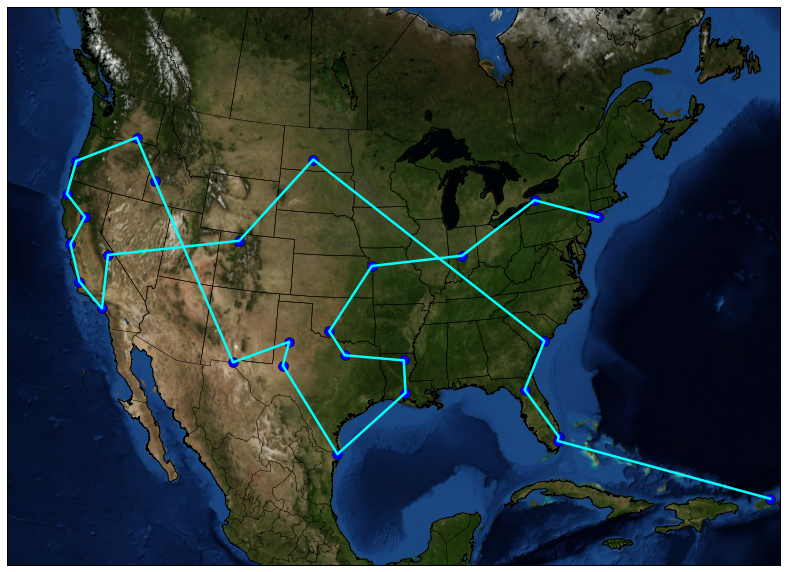

In [62]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(llcrnrlon=-120, llcrnrlat=15, urcrnrlon=-48,
              urcrnrlat=50, projection='lcc', lat_1=33, lat_2=45,
              lon_0=-95, resolution='i', area_thresh=10000)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()
map.drawstates()

# Fill the land with grey
map.bluemarble()

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')


# Plot 50th percentile
latitude_greedy_solution_coordinates = greedy_solution_coordinates['Latitude'].values
longitude_greedy_solution_coordinates = greedy_solution_coordinates['Longitude'].values
x,y = map(longitude_greedy_solution_coordinates, latitude_greedy_solution_coordinates)
for ind, val in enumerate(zip(x,y)):
    map.plot(val[0], val[1], 'bo', markersize=10)
plt.plot(xx,yy, color='cyan',ls='-',linewidth=2.5 )

# Show and save the map
plt.savefig('Map_init.png', transparent=True)
plt.show()

The total flight times for each of the 3 scenarios and the greedy algorithm are as follow:

In [60]:
print "Flight time greedy algorithm", compute_energy(initial_NBM_25, mat_NBM_25)/60,compute_energy(initial_NBM_50, mat_NBM_50)/60, compute_energy(initial_NBM_75, mat_NBM_75)/60
print "Flight time SA:", np.min(maximum_NBM_25)/60, np.min(maximum_NBM_50)/60, np.min(maximum_NBM_75)/60

Flight time greedy algorithm 42.9328920785 43.7287254118 45.1745587452
Flight time SA: 40.9566396861 41.4040895495 42.397794326
